In [3]:
from pymummer import coords_file, alignment, nucmer
import subprocess
import pandas as pd
import re
import numpy as np
from unionfind import unionfind
import random
import glob


def compare_fastANI(reference_file, query_file):
    """
    Use Mummer to find similarity between strains.
    """
    results_file = "temp.txt"

    subprocess.run(["fastANI", "-r", reference_file, "-q", query_file, "-o", results_file], 
                   stdout=subprocess.DEVNULL,
                   stderr=subprocess.DEVNULL)
    with open(results_file, "r") as f:
        fastANI_res = f.readline()
        res = float(fastANI_res.split('\t')[2])
    
    subprocess.run(["rm", results_file])
    return res / 100
    
    #alignments = [coord for coord in file_reader if not coord.is_self_hit()] #Remove self hits
    #print(alignments)

def calculate_pairwise_distance(genome_list):
    """
    Calculate the pairwise distance using Jaccard index, and store it in a 
    distance matrix.
    """
    distance_matrix = np.zeros((len(genome_list), len(genome_list)))
    for i in range(len(genome_list)):
        for j in range(i+1, len(genome_list)):
            distance = min(
                1-compare_fastANI(genome_list[i], genome_list[j]),
                1-compare_fastANI(genome_list[j], genome_list[i])
            )
            print(i, j, distance)
            distance_matrix[i][j] = distance_matrix[j][i] = distance
    
    return distance_matrix
    
def hierarchical_clustering(genome_list, distance_matrix, threshold):
    #distance_matrix = _calculate_pairwise_distance(genome_list)
    u = unionfind(len(genome_list))
    for i in range(len(genome_list)):
        for j in range(i+1, len(genome_list)):
            if distance_matrix[i][j] <= threshold:
                u.unite(i, j)
    
    return u.groups()

def sample(genome_list, groups):
    res = []
    for i in groups:
        res.append(genome_list[random.sample(i, 1)[0]])

    return res


In [5]:
distance_matrix = calculate_pairwise_distance(glob.glob("../data/Staphylococcus_aureus/*.fna"))

0 1 0.022592999999999974
0 2 0.019775000000000098
0 3 0.020399000000000056
0 4 0.024017000000000066
0 5 0.022540000000000004
0 6 0.023632000000000097
0 7 0.022739999999999982
0 8 0.023928999999999978
0 9 0.025368999999999975
0 10 0.023075999999999985
0 11 0.021666000000000074
0 12 0.016085999999999934
0 13 0.022857000000000016
0 14 0.02516000000000007
0 15 0.02142799999999989
0 16 0.02373500000000006
0 17 0.020938000000000012
0 18 0.020676000000000028
0 19 0.024585999999999997
1 2 0.013765999999999945
1 3 0.013623000000000052
1 4 0.010182999999999942
1 5 0.0006169999999999787
1 6 0.010705999999999993
1 7 0.0014019999999999033
1 8 0.010649999999999937
1 9 0.014403999999999972
1 10 0.0015609999999999236
1 11 0.016967000000000065
1 12 0.022768999999999928
1 13 0.0006959999999999189
1 14 0.012812999999999963
1 15 0.019907999999999926
1 16 0.010982000000000047
1 17 0.02504800000000007
1 18 0.025307999999999997
1 19 0.011596999999999968
2 3 0.0025330000000000075
2 4 0.0067629999999999635
2 5

<Axes: >

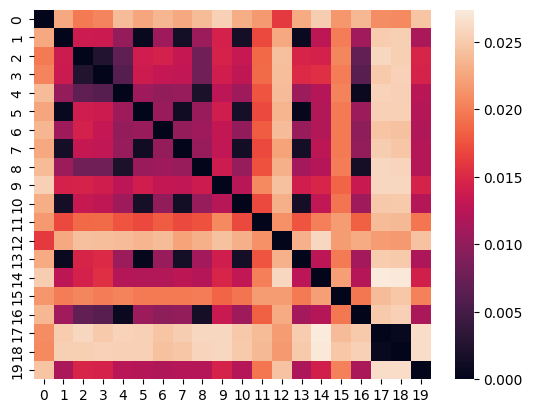

In [6]:
import seaborn

seaborn.heatmap(distance_matrix)

In [11]:
groups = hierarchical_clustering(glob.glob("../data/Staphylococcus_aureus/*.fna"), distance_matrix, 0.01)
groups

[[0],
 [9],
 [11],
 [12],
 [14],
 [15],
 [1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 16],
 [17, 18],
 [19]]

In [13]:
sampled_genomes = sample(glob.glob("../data/Staphylococcus_aureus/*.fna"), groups)
sampled_genomes

['../data/Staphylococcus_aureus/GCA_023647375.1.fna',
 '../data/Staphylococcus_aureus/GCA_003186125.1.fna',
 '../data/Staphylococcus_aureus/GCA_900483655.1.fna',
 '../data/Staphylococcus_aureus/GCA_023744765.1.fna',
 '../data/Staphylococcus_aureus/GCA_024454775.1.fna',
 '../data/Staphylococcus_aureus/GCA_010363815.1.fna',
 '../data/Staphylococcus_aureus/GCA_022214055.1.fna',
 '../data/Staphylococcus_aureus/GCA_001899965.1.fna',
 '../data/Staphylococcus_aureus/GCA_014335265.1.fna']

In [14]:
for i in sampled_genomes:
    subprocess.run(["mkdir", "-p", "../data/sampled_genomes"])
    subprocess.run(["cp", i, "../data/sampled_genomes"])